In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
%matplotlib inline
import numpy
import os
import yaml 
import copy
import sklearn
import h5py
import sys 
import matplotlib
import io
import pickle
import random
import array
import json

from cycler import cycler
from matplotlib import pyplot
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter, ImageMagickFileWriter
from scipy.spatial import distance
from scipy import stats
from banditopt import algorithms, utils, objectives
from collections import defaultdict
from tqdm.auto import tqdm, trange
from PIL import Image

from banditopt.objectives import Resolution

to_insert = "../.."
while to_insert in sys.path:
    sys.path.remove(to_insert)
sys.path.insert(0, to_insert)

from src.tools import datamap_generator
from src.create import create_microscope, create_dymin_microscope, create_rescue_microscope
from src.experiment import Experiment
from src.defaults import P_EX, P_STED, PDT
from src.tools import ParameterSpaceGenerator
from src.articulation import PreferenceArticulator

# FIRST EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.5801577460614683e-09,  # found through optim
#         750: 4.450819912845956e-09 / 100,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6,
#     "k0" : 0,
#     "k1" : 1.3e-15,
#     "b" : 1.4,
#     "triplet_dynamic_frac" : 0,    
# }

fluo = { # ATTO647N
    "lambda_": 690e-9, # Figure 1, Oracz2017
    "qy": 0.65,  # Product Information: ATTO 647N (ATTO-TEC GmbH)
    "sigma_abs": {
        635: 1.0e-20, #Table S3, Oracz2017
        750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz2017
    },
    "sigma_ste": {
        750: 4.8e-22, #Table S3, Oracz2017
    },
    "tau": 3.5e-9, #Table S3, Oracz2017
    "tau_vib": 1.0e-12, #t_vib, Table S3, Oracz2017 
    "tau_tri": 25e-6, # pasted from egfp
    "k0": 0, #Table S3, Oracz2017
    "k1": 1.3e-15, #Table S3,  (changed seemingly wrong unit: 5.2 × 10−10 / (100**2)**1.4)
#     "b":1.4, #Table S3, Oracz2017
    "b":1.45, #Table S3, Oracz2017    
    "triplet_dynamics_frac": 0, #Ignore the triplet dynamics by default
}

objective = {"transmission" : {488: 0.84, 535: 0.85, 550: 0.86, 585: 0.85, 575: 0.85, 635: 0.85, 690: 0.85, 750: 0.85}}
laser_ex = {"lambda_" : 635e-9}
laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01, "anti_stokes" : True}
num_mol = 100

# # SECOND EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 2.98094869e-09,  # found through optim
#         750: 9.15758276e-08 / 1000,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 450

# # OTHER EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.053e-05,  # found through optim
#         750: 4.26e-09,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 23




In [45]:
BOUNDS = {
    "Resolution" : {
        "min" : 40.,
        "max" : 70.,
    },
    "SNR" : {
        "min" : 0.1,
        "max" : numpy.inf,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.3,
    },
    "Squirrel" : {
        "min" : 0.,
        "max" : 0.11,
    }    
}
# Define the objectives and regressors here
obj_dict = {
    "SNR" : objectives.Signal_Ratio(75),
    "Bleach" : objectives.Bleach(),
    "Resolution" : objectives.Resolution(pixelsize=20e-9),
    "Squirrel" : objectives.Squirrel(normalize=True)
}


cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="space",
#     colors=["#45d7cd", "#ffc949"]
    colors=["#45d7cd", "#ff5554"]
#     colors=["#ffc949", "#ff5554"]
#     colors = ["#1b5bdb", "#ffc949"]
)
matplotlib.cm.register_cmap(cmap=cmap)
matplotlib.cm.register_cmap(cmap=cmap.reversed())

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
#     colors=["#45d7cd", "#ff5554"]
#     colors=["#ffc949", "#ff5554"]
#     colors = ["#1b5bdb", "#ffc949"]
)
matplotlib.cm.register_cmap(cmap=cmap)
matplotlib.cm.register_cmap(cmap=cmap.reversed())

def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        dirname = os.path.dirname(savepath)
        basename = os.path.basename(savepath)
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))  
        
def isin_bounds(y, obj_name):
    """
    Verifies wheter the objectives are within the bounds
    
    :param y: A `numpy.ndarray` of the objective values
    :param obj_name: A `str` of the objective name
    
    :return : A `numpy.ndarray` of the parameters
    """
    return numpy.logical_and(y >= BOUNDS[obj_name]["min"], y <= BOUNDS[obj_name]["max"])

def rescale_obj(y, obj_name):
    """
    Rescales the objectives using the scaling function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    
    :return : A `numpy.ndarray` of the rescaled array
    """
    return (y) * (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"]) + CONFIG["obj_normalization"][obj_name]["min"]

def scale_obj(y, obj_name):
    """
    Scales the objectives using the scaling min max function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    
    :return : A `numpy.ndarray` of the rescaled array    
    """
    return (y - CONFIG["obj_normalization"][obj_name]["min"]) / (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"])
    
def scale_param(X, param_name):
    """
    Scales the parameters using the scaling function
    
    :param X: A `numpy.ndarray` of the parameters
    :param param_name: A `str` of the parameter
    
    :return : A `numpy.ndarray` of the parameters
    """
    m = CONFIG["x_mins"][CONFIG["param_names"].index(param_name)]
    M = CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    return (X - m) / (M - m)

def load_data(path, trial="last", return_pareto=False):
    """
    Loads the data from the given path
    
    :param path: A `str` of the path
    :param trial: An `int` or `str` of the id to load
    
    :returns : A `dict` of the X
               A `dict` of the y
    """
    from deap import base, creator, tools
    
    with h5py.File(os.path.join(path, "optim.hdf5"), "r") as file:
        if trial == "all":
            X, y = [], []
            for key in sorted(file["X"].keys(), key=lambda x : int(x)):
                X.append(file["X"][key][()])
                y.append(file["y"][key][()])                
            X = numpy.concatenate(X, axis=0)
            y = numpy.concatenate(y, axis=0)
        elif isinstance(trial, slice):
            X, y = [], []
            for key in list(sorted(file["X"].keys(), key=lambda x : int(x)))[trial]:
                X.append(file["X"][key][()])
                y.append(file["y"][key][()])
            X = numpy.concatenate(X, axis=0)
            y = numpy.concatenate(y, axis=0)                            
        else:
            if trial == "last":
                trial = str(max(map(int, file["X"].keys())))
                print(trial)
            X = file["X"][trial][()]
            y = file["y"][trial][()]
    if return_pareto:
        pop = array_to_population(y)
        pareto_y = numpy.array(tools.sortLogNondominated(pop, len(pop), first_front_only=True))
        indices = [i for i, _y in enumerate(pareto_y) if _y in y]
        X, y = X[indices], y[indices]
    return X, y

def array_to_population(values, weights=None):
    """
    Converts a `numpy.ndarray` into a population
    
    :param values: A `numpy.ndarray` of `Individual`
    :param weights: A `list` of weights for each dimensions
    
    :returns : A `list` of `Individual`
    """
    from deap import base, creator, tools
    
    if isinstance(weights, type(None)):
        weights = [-1] * values.shape[-1]
    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

    pop = []
    for value in values:
        ind = creator.Individual(value)
        ind.fitness.values = value
        pop.append(ind)
    
    del creator.FitnessMin, creator.Individual
    return pop

/tmp/ipykernel_2902770/941948992.py:35: UserWarning: Trying to register the cmap 'space' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap)
/tmp/ipykernel_2902770/941948992.py:36: UserWarning: Trying to register the cmap 'space_r' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap.reversed())
/tmp/ipykernel_2902770/941948992.py:45: UserWarning: Trying to register the cmap 'nice-prism' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap)
/tmp/ipykernel_2902770/941948992.py:46: UserWarning: Trying to register the cmap 'nice-prism_r' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap.reversed())


In [46]:

PATH = "../../data/exhaustive/20220906-161541_DyMIN_NSGA_None"
CONFIG = yaml.load(open(os.path.join(PATH, "config.yml"), "r"), Loader=yaml.Loader)
# Defines necessary variables
NDIMS, param_space_bounds, N_POINTS, conditions = ParameterSpaceGenerator(CONFIG["microscope"])(
    CONFIG["param_names"], CONFIG["x_mins"], CONFIG["x_maxs"], CONFIG["n_divs_default"]
)
labels = [f"{param}" for i, param in enumerate(CONFIG["param_names"]) for n in range(NDIMS[i])]
X, y = load_data(PATH, trial="last", return_pareto=True)

mask = numpy.all([
    isin_bounds(_y, obj_name) for obj_name, _y in zip(CONFIG["obj_names"], y.T)
], axis=0)


234


In [47]:
P_STED = 15e-3
P_EX = 1.5e-6
PDT = 5.0e-6

NUM_ACQ = 5
all_histories = []
for i, parameters in enumerate(tqdm(X[mask], desc="Parameters")):
    molecules_disposition, positions = datamap_generator(
        shape = (128, 128),
        sources = 50,
        molecules = num_mol,
        shape_sources = (2, 2),
        random_state = 42 + i
    )
    
    P_STED, P_EX, PDT, threshold_count_1, threshold_count_2, decision_time_1, decision_time_2 = parameters

    experiment = Experiment()

    # Creates the STED microscope
    sted_microscope, datamap, sted_params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
    )
    experiment.add("STED", sted_microscope, datamap, sted_params)
    
    # Creates the DyMIN microscope
    dymin_microscope, datamap, dymin_params = create_dymin_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        microscope = {
            "scale_power" : [0., 0.25, 1.],
#             "decision_time" : [10e-6, 10e-6, -1],
            "decision_time" : [decision_time_1, decision_time_2, -1],            
            "threshold_count" : [threshold_count_1, threshold_count_2, 0]
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}        
    )
    experiment.add("DyMIN", dymin_microscope, datamap, dymin_params)

    histories = experiment.acquire_all(NUM_ACQ, bleach=True, processes=2, verbose=False)
    
    all_histories.append(histories)

Parameters:   0%|          | 0/6 [00:00<?, ?it/s]

STED [350, 68.09415768576291, 66.28934290447268, 350, 350, 70.28688524590164]
DyMIN [350, 52.031639397551196, 53.76777516515507, 350, 350, 79.08432147562584]


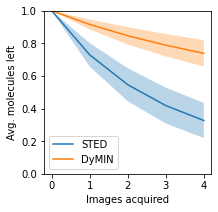

In [48]:
%matplotlib inline

resolution_objective = Resolution(20e-9)

def get_molecules_left(history):
    molecules = history["datamap"][:, history["datamap"][0] > 0]
    molecules = molecules.mean(axis=-1) / molecules.mean(axis=-1)[0]    
    return molecules

# Bleaching curve
fig, ax = pyplot.subplots(figsize=(3,3))
for microscope_name in ["STED", "DyMIN"]:
    
    resolutions = [resolution_objective.evaluate([histories[microscope_name]["acquisition"][-1]], None, None, None, None) for histories in all_histories]
    print(microscope_name, resolutions)
    
    molecules = [get_molecules_left(histories[microscope_name]) for histories in all_histories]
    mean, std = numpy.mean(molecules, axis=0), numpy.std(molecules, axis=0)

    x = numpy.arange(len(mean))
    ax.plot(x, mean, label=microscope_name)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)    

ax.set(
    xlabel="Images acquired", ylabel="Avg. molecules left", ylim=(0, 1)
)
ax.legend()
# fig.savefig("./panels/bleach_curve.pdf", transparent=True, bbox_inches="tight")
# savefig(fig, ax, "./panels/bleach_curve", save_white=True)
pyplot.show()

19


<IPython.core.display.Javascript object>


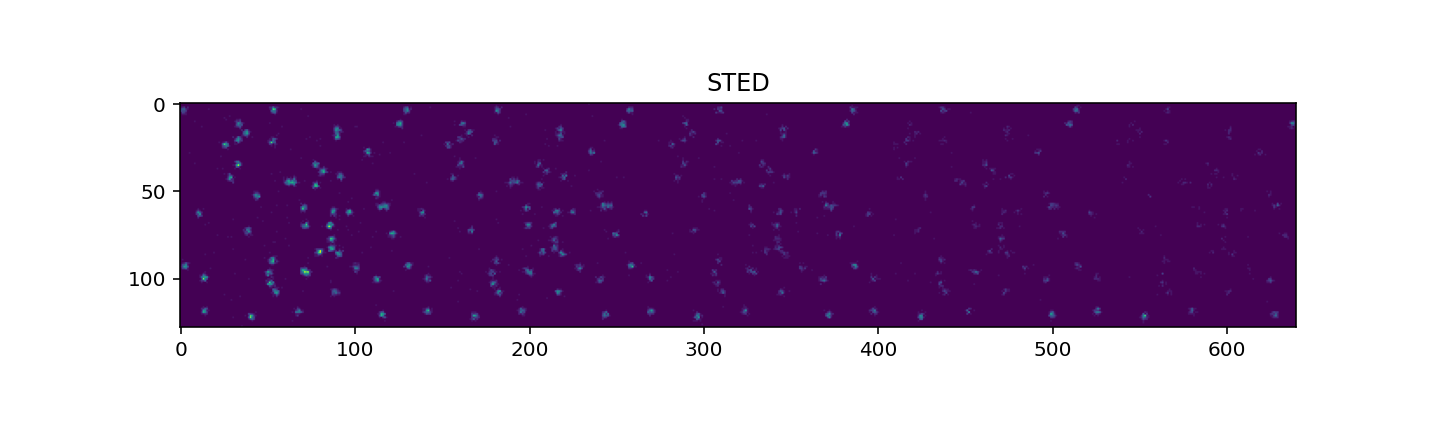

21


<IPython.core.display.Javascript object>


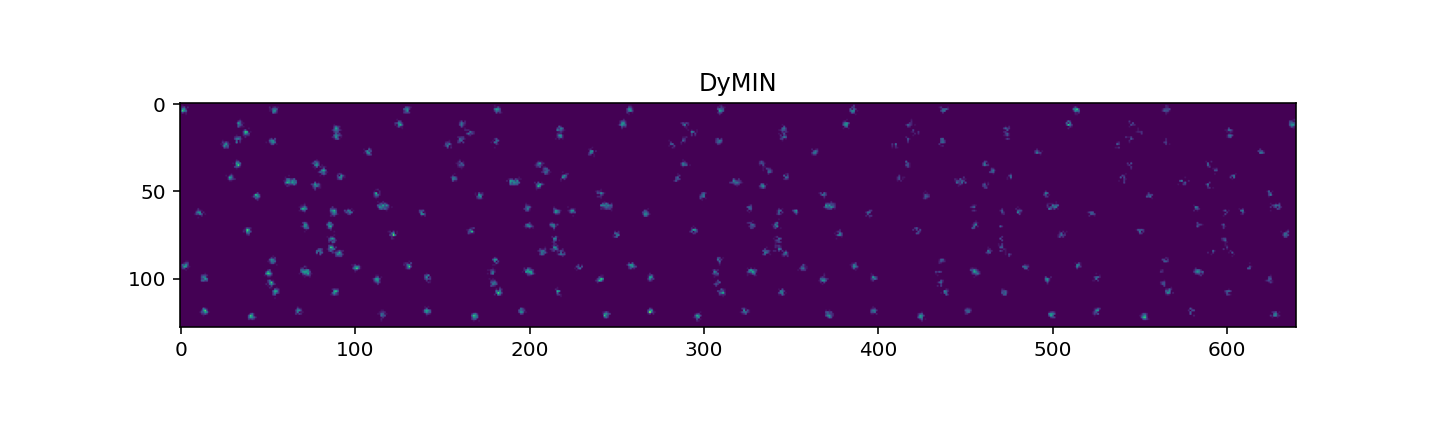

In [49]:
%matplotlib notebook
def show_montage(images, nrows=1, ncols=10):
    """
    Creates a 2d montage from the scores
    """    
    h, w = (128, 128)
    collage = Image.new("I;16", (ncols * w, nrows * h))
    for j in range(nrows):
        for i in range(ncols):

            image = images[j][i]

            pil_img = Image.fromarray(image, "I;16")
            # Resizes the image
            pil_img = pil_img.resize(size=(w, h), resample=Image.Resampling.NEAREST)
            collage.paste(pil_img, (i * w, j * h))
    return collage
            
image_ids = numpy.clip(numpy.arange(0, NUM_ACQ + 5, 5) - 1, 0, NUM_ACQ)
image_ids = numpy.clip(numpy.arange(0, NUM_ACQ), 0, NUM_ACQ)
# image_ids = [0, 1]
for microscope_name in ["STED", "DyMIN"]:
    
    history = all_histories[0][microscope_name]

    acquisitions = history["acquisition"][image_ids]
    acquisitions = acquisitions[numpy.newaxis, ...].astype(numpy.uint16)
    print(acquisitions.max())

    collage = show_montage(acquisitions, nrows=1, ncols=len(image_ids)) 
    collage = numpy.array(collage)
    fig,ax = pyplot.subplots(figsize=(10,3))
    ax.set_title(microscope_name)
    ax.imshow(collage)
    pyplot.show()
#     tifffile.imwrite(f"./panels/example-image_{microscope_name}.tif", collage.astype(numpy.uint16))

In [57]:
import random
def minimum(x, y, z):
    if x < y:
        y = x
    if y < z:
        z = y
    return z

for _ in range(5):
    numbers = [random.random() for _ in range(3)]
    print(numbers)
    print(minimum(*numbers))

[0.17436257279558476, 0.6062784034050546, 0.47836055450924575]
0.17436257279558476
[0.9231868003053729, 0.051961205417893064, 0.027904098888072548]
0.027904098888072548
[0.010179277574692502, 0.9544379421620456, 0.11983178377282078]
0.010179277574692502
[0.803761615395295, 0.39336908543982185, 0.8870239493649839]
0.39336908543982185
[0.478690524089729, 0.27563879127940105, 0.3521219387955249]
0.27563879127940105
